In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import VotingRegressor

file_path = '/content/drive/MyDrive/_All_Cities_Cleaned.csv'  # Update this with the correct path if needed
df = pd.read_csv(file_path)

# Display dataset information
print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns)
df.head()

df.fillna(0, inplace=True)

# Feature Engineering
df['price_per_sqft'] = df['price'] / df['area']  # Price per square foot
df['log_area'] = np.log1p(df['area'])           # Log-transform area
df['log_price'] = np.log1p(df['price'])         # Log-transform price

# Features and target
X = df[['area', 'bedroom', 'bathroom', 'price_per_sqft', 'log_area', 'layout_type', 'property_type', 'furnish_type', 'city']]
y = df['log_price']  # Using log-transformed price as the target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split into training and testing sets successfully!")

"""# New Section"""

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

# Define numerical and categorical features
num_features = ['area', 'bedroom', 'bathroom', 'price_per_sqft', 'log_area']  # Example numerical columns
cat_features = ['layout_type', 'property_type', 'furnish_type', 'city']       # Example categorical columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  # Scale numerical features
        ('cat', OneHotEncoder(drop='first'), cat_features)  # Encode categorical features
    ]
)

# Verify preprocessing works on data
X_train_processed = preprocessor.fit_transform(X_train)
print("Preprocessed training data shape:", X_train_processed.shape)



# Hyperparameter grid
from sklearn.model_selection import GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2
)

# Pipeline
xgb_model = Pipeline(steps=[('preprocessor', preprocessor), ('model', grid_search_xgb)])
xgb_model.fit(X_train, y_train)


Dataset loaded successfully!
Shape: (193011, 10)
Columns: Index(['seller_type', 'bedroom', 'layout_type', 'property_type', 'locality',
       'price', 'area', 'furnish_type', 'bathroom', 'city'],
      dtype='object')
Data split into training and testing sets successfully!
Preprocessed training data shape: (154408, 20)
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', 'bedroom',
                                                   'bathroom', 'price_per_sqft',
                                                   'log_area']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['layout_type',
                                                   'property_type',
                                                   'furnish_type', 'city'])])),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_byleve...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...),
                              param_grid={'colsample_bytree': [0.8, 1.0],
                                          'learning_rate': [0.01, 0.1, 0.3],
                                          'max_depth': [3, 5, 7],
                                          'n_estimators': [100, 200, 300],
                                          'subsample': [0.8, 1.0]},
                              scoring='neg_mean_squared_error', verbose=2))])

In [ ]:

# Best parameters
best_xgb_params = grid_search_xgb.best_params_
print("Best XGBoost Parameters:", best_xgb_params)



import joblib
# Save the pipeline with the best XGBoost model
xgb_pipeline_filename = 'xgb_pipeline_1.pkl'
joblib.dump(xgb_model, xgb_pipeline_filename)

print(f"Model saved successfully to {xgb_pipeline_filename}!")

Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Model saved successfully to xgb_pipeline_1.pkl!


In [ ]:

# Define the ensemble model with preprocessing
from sklearn.metrics import mean_squared_error
'''
# Compute RMSE manually
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Take the square root manually
'''
ensemble_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Add preprocessing
    ('ensemble', VotingRegressor(
        estimators=[
            ('xgboost', grid_search_xgb.best_estimator_)
        ]
    ))
])

# Train the ensemble model
ensemble_pipeline.fit(X_train, y_train)

print("Ensemble model trained successfully!")

import sklearn
print(f"Scikit-Learn version: {sklearn.__version__}")

# Train the ensemble pipeline
ensemble_pipeline.fit(X_train, y_train)
print("Ensemble pipeline trained successfully!")
'''
# Define the evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print("Model Evaluation Metrics:")
    print(f"Root Mean Squared Error (RMSE): ₹{rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

# Evaluate the trained pipeline
evaluate_model(ensemble_pipeline, X_test, y_test)

'''

Ensemble model trained successfully!
Scikit-Learn version: 1.6.1
Ensemble pipeline trained successfully!


'\n# Define the evaluation function\ndef evaluate_model(model, X_test, y_test):\n    y_pred = model.predict(X_test)\n    rmse = mean_squared_error(y_test, y_pred, squared=False)\n    r2 = r2_score(y_test, y_pred)\n\n    print("Model Evaluation Metrics:")\n    print(f"Root Mean Squared Error (RMSE): ₹{rmse:.2f}")\n    print(f"R² Score: {r2:.4f}")\n\n# Evaluate the trained pipeline\nevaluate_model(ensemble_pipeline, X_test, y_test)\n\n'

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Ensure function compatibility
    try:
        rmse = mean_squared_error(y_test, y_pred, squared=False)  # Named argument
    except TypeError:
        rmse = mean_squared_error(y_test, y_pred, False)  # Positional argument

    r2 = r2_score(y_test, y_pred)

    print("Model Evaluation Metrics:")
    print(f"Root Mean Squared Error (RMSE): ₹{rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

evaluate_model(ensemble_pipeline, X_test, y_test)


TypeError: too many positional arguments

In [ ]:
import inspect
print(inspect.signature(evaluate_model))


(model, X_test, y_test)


In [ ]:
print(evaluate_model)


<function evaluate_model at 0x782334b3e520>


In [ ]:

# Install Gradio if not already installed
!pip install gradio

import gradio as gr
import pandas as pd
import numpy as np
import joblib

# Load the trained ensemble model
ensemble_pipeline = joblib.load('/content/xgb_pipeline_1.pkl')

# Define a simplified prediction function
def predict_price(area, bedroom, bathroom, layout_type, property_type, furnish_type, city):
    layout_options = {1: 'BHK', 2: 'RK'}
    property_options = {1: 'Apartment', 2: 'Independent House'}
    furnish_options = {1: 'Furnished', 2: 'Semi-Furnished', 3: 'Unfurnished'}
    city_options = {1: 'Ahmedabad', 2: 'Mumbai', 3: 'Delhi', 4: 'Bangalore', 5: 'Chennai'}

    # Map numeric inputs to string values
    layout_type = layout_options.get(layout_type, 'BHK')
    property_type = property_options.get(property_type, 'Apartment')
    furnish_type = furnish_options.get(furnish_type, 'Furnished')
    city = city_options.get( city ) #'Ahmedabad'

    # Create input dataframe
    input_data = pd.DataFrame({
        'area': [area],
        'bedroom': [bedroom],
        'bathroom': [bathroom],
        'price_per_sqft': [area],  # Placeholder
        'log_area': [np.log1p(area)],
        'layout_type': [layout_type],
        'property_type': [property_type],
        'furnish_type': [furnish_type],
        'city': [city]
    })

    # Predict log price and convert to original scale
    try:
        predicted_log_price = ensemble_pipeline.predict(input_data)[0]
        predicted_price = np.exp(predicted_log_price)
        return f"Predicted Price: ₹{predicted_price:.2f}"
    except Exception as e:
        return f"Prediction error: {str(e)}"

# Create Gradio interface
iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Area (sq ft)"),
        gr.Number(label="Bedrooms"),
        gr.Number(label="Bathrooms"),
        gr.Dropdown([1, 2], label="Layout Type (1=BHK, 2=RK)"),
        gr.Dropdown([1, 2], label="Property Type (1=Apartment, 2=Independent House)"),
        gr.Dropdown([1, 2, 3], label="Furnish Type (1=Furnished, 2=Semi-Furnished, 3=Unfurnished)"),
        gr.Dropdown([1, 2, 3, 4, 5], label="City (1=Ahmedabad, 2=Mumbai, 3=Delhi, 4=Bangalore, 5=Chennai)")
    ],
    outputs="text",
    title="Real Estate Price Prediction",
    description="Enter the details to get the predicted house price."
)

# Launch the interface
iface.launch()

def get_user_input_and_predict_easy():
    """
    Take simplified numeric input from the user and predict the house price.
    """
    print("Enter the following details to predict the house price:\n")

    # Numeric options for layout type
    layout_options = {1: 'BHK', 2: 'RK'}
    print("Layout Type Options:")
    for key, value in layout_options.items():
        print(f"{key}: {value}")
    layout_choice = int(input("\nSelect Layout Type (1/2): "))
    layout_type = layout_options.get(layout_choice, 'BHK')

    # Numeric options for property type
    property_options = {1: 'Apartment', 2: 'Independent House'}
    print("\nProperty Type Options:")
    for key, value in property_options.items():
        print(f"{key}: {value}")
    property_choice = int(input("\nSelect Property Type (1/2): "))
    property_type = property_options.get(property_choice, 'Apartment')

    # Numeric options for furnish type
    furnish_options = {1: 'Furnished', 2: 'Semi-Furnished', 3: 'Unfurnished'}
    print("\nFurnish Type Options:")
    for key, value in furnish_options.items():
        print(f"{key}: {value}")
    furnish_choice = int(input("\nSelect Furnish Type (1/2/3): "))
    furnish_type = furnish_options.get(furnish_choice, 'Furnished')

    # Numeric options for city
    cities = {1: 'Ahmedabad', 2: 'Mumbai', 3: 'Delhi', 4: 'Bangalore', 5: 'Chennai'}
    print("\nCity Options:")
    for key, value in cities.items():
        print(f"{key}: {value}")
    city_choice = int(input("\nSelect City (1/2/3/4/5): "))
    city = cities.get(city_choice, 'Ahmedabad')

    # Other numeric inputs
    bedroom = float(input("\nEnter number of bedrooms (e.g., 2, 3): "))
    area = float(input("Enter area in square feet (e.g., 1200): "))
    bathroom = float(input("Enter number of bathrooms (e.g., 1, 2): "))

    try:
        # Create a dictionary of inputs for prediction
        price_per_sqft = area  # Assuming placeholder
        input_data = {
            'bedroom': [bedroom],
            'layout_type': [layout_type],
            'property_type': [property_type],
            'area': [area],
            'furnish_type': [furnish_type],
            'bathroom': [bathroom],
            'city': [city],
            'price_per_sqft': [price_per_sqft],
            'log_area': [np.log(area)]
        }

        # Convert input data to DataFrame
        input_df = pd.DataFrame(input_data)

        # Ensure input matches preprocessing requirements
        preprocessor = ensemble_pipeline.named_steps['preprocessor']
        ensemble_model = ensemble_pipeline.named_steps['ensemble']

        input_preprocessed = preprocessor.transform(input_df)

        # Predict price using the trained pipeline
        predicted_log_price = ensemble_model.predict(input_preprocessed)[0]
        predicted_price = np.exp(predicted_log_price)  # Reverse log transformation

        print(f"\nPredicted Price: ₹{predicted_price:.2f}")
    except Exception as e:
        print("\nError in prediction. Please check your inputs.")
        print(f"Error details: {e}")

get_user_input_and_predict_easy()


In [ ]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Dataset
file_path = '/content/drive/MyDrive/_All_Cities_Cleaned.csv'  # Update this with the correct path if needed
df = pd.read_csv(file_path)

# Display dataset information
print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns)
df.head()

# Feature Engineering
df['log_area'] = np.log1p(df['area'])
df['price_per_sqft'] = df['price'] / df['area']

# Selecting Features and Target
features = ['area', 'bedroom', 'bathroom', 'log_area', 'layout_type', 'property_type', 'furnish_type', 'city']
target = 'price'

X = df[features]
y = df[target]

# Handling Categorical Data
categorical_cols = ['layout_type', 'property_type', 'furnish_type', 'city']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_features = ohe.fit_transform(X[categorical_cols])
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

ohe_df = pd.DataFrame(ohe_features, columns=ohe_feature_names)
X = X.drop(columns=categorical_cols).reset_index(drop=True)
X = pd.concat([X, ohe_df], axis=1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Model Evaluation
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - RMSE: {rmse}, R2 Score: {r2}")

evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")
evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost")

# Save Model
joblib.dump(xgb_model, "house_price_model.pkl")
joblib.dump(ohe, "ohe_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and encoders saved successfully!")


Dataset loaded successfully!
Shape: (193011, 10)
Columns: Index(['seller_type', 'bedroom', 'layout_type', 'property_type', 'locality',
       'price', 'area', 'furnish_type', 'bathroom', 'city'],
      dtype='object')
Random Forest - RMSE: 45538.6232868872, R2 Score: 0.780342652876836
XGBoost - RMSE: 49678.80697529818, R2 Score: 0.7385863531111496
Model and encoders saved successfully!


In [ ]:
!streamlit run "/content/House Price Frontend.py"





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.31.159.25:8501

  Stopping...
  Stopping...


In [ ]:
import streamlit as st
import numpy as np
import pandas as pd
import joblib

# Load trained model and encoders
model = joblib.load("/content/house_price_model.pkl")
ohe = joblib.load("/content/ohe_encoder.pkl")
scaler = joblib.load("/content/scaler.pkl")

# Define input fields
st.title("🏡 House Price Prediction App")
st.write("Enter property details to get estimated price.")

area = st.number_input("Area (sq ft)", min_value=100, max_value=10000, step=10)
bedroom = st.selectbox("Bedrooms", [1, 2, 3, 4, 5])
bathroom = st.selectbox("Bathrooms", [1, 2, 3, 4])
layout_type = st.selectbox("Layout Type", ["BHK", "RK"])
property_type = st.selectbox("Property Type", ["Apartment", "Independent House"])
furnish_type = st.selectbox("Furnishing", ["Unfurnished", "Semi-Furnished", "Fully-Furnished"])
city = st.selectbox("City", ["Mumbai", "Delhi", "Bangalore", "Chennai"])

# Feature Engineering
log_area = np.log1p(area)
data = pd.DataFrame({
    'area': [area], 'bedroom': [bedroom], 'bathroom': [bathroom], 'log_area': [log_area],
    'layout_type': [layout_type], 'property_type': [property_type], 'furnish_type': [furnish_type], 'city': [city]
})

# Encode categorical features
data_encoded = pd.DataFrame(ohe.transform(data[['layout_type', 'property_type', 'furnish_type', 'city']]),
                            columns=ohe.get_feature_names_out())
data = data.drop(columns=['layout_type', 'property_type', 'furnish_type', 'city']).reset_index(drop=True)
data = pd.concat([data, data_encoded], axis=1)

# Scale features
data_scaled = scaler.transform(data)

# Predict price
if st.button("Predict Price"):
    price = model.predict(data_scaled)[0]
    st.success(f"Estimated House Price: ₹ {price:,.2f}")


2025-02-21 08:40:55.404 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-21 08:40:55.610 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-21 08:40:55.613 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-21 08:40:55.616 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-21 08:40:55.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-21 08:40:55.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-21 08:40:55.622 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-21 08:40:55.623 Thread 'MainThread': mi

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/_All_Cities_Cleaned.csv")

# Feature Engineering
df['log_area'] = np.log1p(df['area'])
df['price_per_sqft'] = df['price'] / df['area']

# Selecting Features and Target
features = ['area', 'bedroom', 'bathroom', 'log_area', 'layout_type', 'property_type', 'furnish_type', 'city']
target = 'price'

X = df[features]
y = df[target]

# Handling Categorical Data
categorical_cols = ['layout_type', 'property_type', 'furnish_type', 'city']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_features = ohe.fit_transform(X[categorical_cols])
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

ohe_df = pd.DataFrame(ohe_features, columns=ohe_feature_names)
X = X.drop(columns=categorical_cols).reset_index(drop=True)
X = pd.concat([X, ohe_df], axis=1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2
)

grid_search_xgb.fit(X_train_scaled, y_train)
best_xgb_params = grid_search_xgb.best_params_
print("Best XGBoost Parameters:", best_xgb_params)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2
)

grid_search_rf.fit(X_train_scaled, y_train)
best_rf_params = grid_search_rf.best_params_
print("Best Random Forest Parameters:", best_rf_params)

# Define the ensemble model
ensemble_pipeline = Pipeline(steps=[
    ('ensemble', VotingRegressor(
        estimators=[
            ('random_forest', grid_search_rf.best_estimator_),
            ('xgboost', grid_search_xgb.best_estimator_)
        ]
    ))
])

# Train the ensemble model
ensemble_pipeline.fit(X_train_scaled, y_train)
print("Ensemble model trained successfully!")

# Save Model
joblib.dump(ensemble_pipeline, "house_price_model.pkl")
joblib.dump(ohe, "ohe_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and encoders saved successfully!")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END 

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/_All_Cities_Cleaned.csv")

# Feature Engineering
df['log_area'] = np.log1p(df['area'])
df['price_per_sqft'] = df['price'] / df['area']

# Selecting Features
features = ['area', 'bedroom', 'bathroom', 'log_area', 'layout_type', 'property_type', 'furnish_type', 'city']
target = 'price'

X = df[features]
y = df[target]

# Handling Categorical Data
categorical_cols = ['layout_type', 'property_type', 'furnish_type', 'city']
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_features = ohe.fit_transform(X[categorical_cols])
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

ohe_df = pd.DataFrame(ohe_features, columns=ohe_feature_names)
X = X.drop(columns=categorical_cols).reset_index(drop=True)
X = pd.concat([X, ohe_df], axis=1)

# Standardizing Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
'''
# 📌 1. **Histogram: Price Distribution**
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.xlabel('House Price (₹)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.show()

# 📌 2. **Scatter Plot: Area vs. Price**
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['area'], y=df['price'], alpha=0.5, color='red')
plt.xlabel('Area (sq. ft.)')
plt.ylabel('Price (₹)')
plt.title('Scatter Plot: Area vs. Price')
plt.show()


print("✅ Data Analysis & Visualizations Complete!")
'''


'\n# 📌 1. **Histogram: Price Distribution**\nplt.figure(figsize=(8, 5))\nsns.histplot(df[\'price\'], bins=50, kde=True, color=\'blue\')\nplt.xlabel(\'House Price (₹)\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Distribution of House Prices\')\nplt.show()\n\n# 📌 2. **Scatter Plot: Area vs. Price**\nplt.figure(figsize=(8, 5))\nsns.scatterplot(x=df[\'area\'], y=df[\'price\'], alpha=0.5, color=\'red\')\nplt.xlabel(\'Area (sq. ft.)\')\nplt.ylabel(\'Price (₹)\')\nplt.title(\'Scatter Plot: Area vs. Price\')\nplt.show()\n\n# 📌 3. **Box Plot: Price by City**\nplt.figure(figsize=(10, 5))\nsns.boxplot(x=\'city\', y=\'price\', data=df)\nplt.xticks(rotation=45)\nplt.xlabel(\'City\')\nplt.ylabel(\'Price (₹)\')\nplt.title(\'House Price Distribution by City\')\nplt.show()\n\n# 📌 4. **Correlation Heatmap**\ncorr_matrix = df[[\'price\', \'area\', \'bedroom\', \'bathroom\', \'log_area\', \'price_per_sqft\']].corr()\nplt.figure(figsize=(8, 5))\nsns.heatmap(corr_matrix, annot=True, cmap=\'coolwarm\', fmt=".2

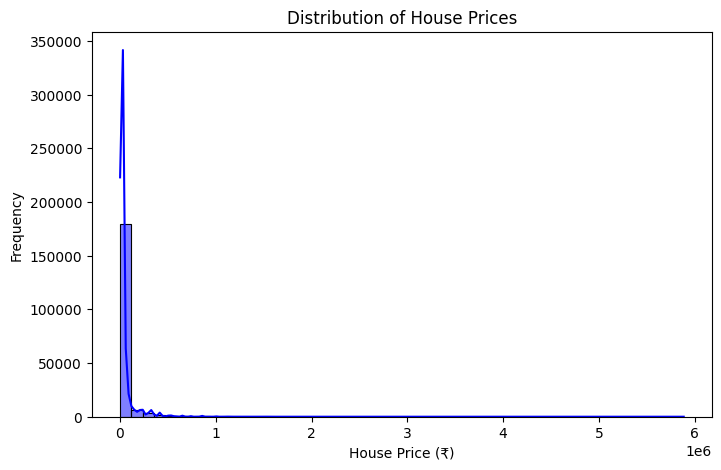

In [29]:
# 📌 1. **Histogram: Price Distribution**
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.xlabel('House Price (₹)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.show()

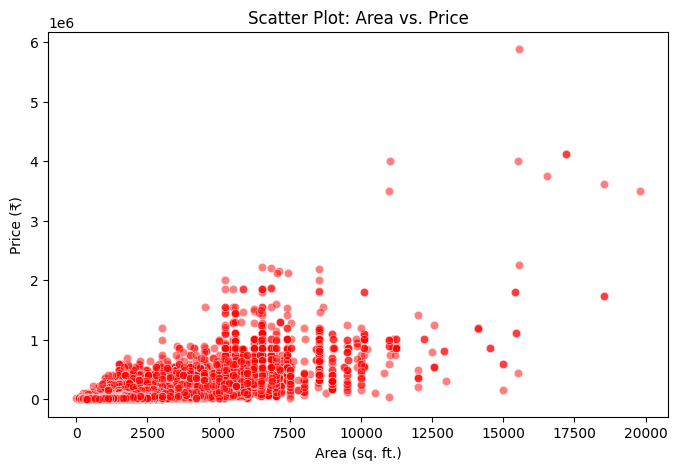

In [30]:
# 📌 2. **Scatter Plot: Area vs. Price**
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['area'], y=df['price'], alpha=0.5, color='red')
plt.xlabel('Area (sq. ft.)')
plt.ylabel('Price (₹)')
plt.title('Scatter Plot: Area vs. Price')
plt.show()


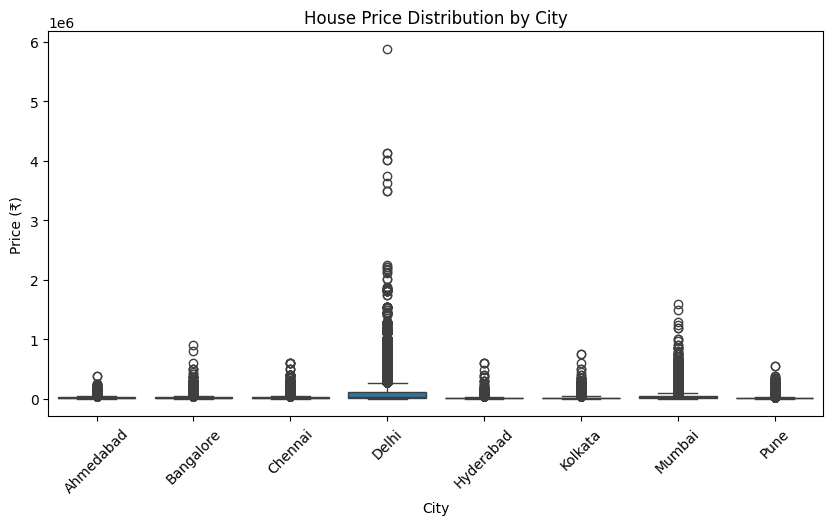

In [34]:

# 📌 3. **Box Plot: Price by City**
plt.figure(figsize=(10, 5))
sns.boxplot(x='city', y='price', data=df)
plt.xticks(rotation=45)
plt.xlabel('City')
plt.ylabel('Price (₹)')
plt.title('House Price Distribution by City')
plt.show()



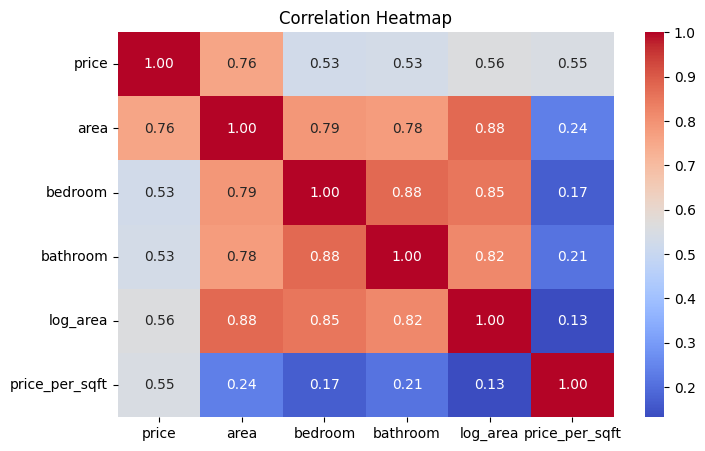

In [33]:

# 📌 4. **Correlation Heatmap**
corr_matrix = df[['price', 'area', 'bedroom', 'bathroom', 'log_area', 'price_per_sqft']].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()